In [68]:
# !pip install simpy
import numpy as np
import pandas as pd
import pickle as pkl
import simpy
import os
import matplotlib.pyplot as plt
import sys
from sim_func import Sim_func
import pymc as pm

from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from sklearn.metrics import mean_squared_error

## Welcome to the Queue quiz

### You are now incharge of the a queueing system in your work place. Your factory works 24/7 and creates flawless semi-conducter chips.

### Jobs are arriving with a constant rate, on average one every 12 seconds. However, the service times changes with time. We split the week into a 168 grid, where we have 7 days and 24 hours within a single day. For each cell in the grid, that is a combination of a day and an hour we have different service rate. 


## Part 1:

### We first focus on a single service time of a single cell in the grid. Being more specific, Monday from 08:00 to 09:00. 
### In event_log_single_ser below you have pandas dataframe with the eventlog of this specific cell. 

### Your jobs is to understand what is the average service time and its distirbution using Bayesian analysis.

In [69]:
event_log_single_ser = pkl.load(open('../data_queueing_quiz/event_log_single_ser.pkl', 'rb'))
event_log_single_ser.head()

,customer_id,num_cust,event,time_stamp,day,hour
0,0,0,Arrival,30.105252,2,8
1,0,1,Enter_service,30.105252,2,8
2,0,0,Departure,37.798838,2,8
3,1,0,Arrival,38.750399,2,8
4,1,1,Enter_service,38.750399,2,8


## Explanation about the dataframe columns:

### 1. customer_id: the id of customer, each customer has is own id.
### 2. num_cust: the number of customers in the system (including service) prior to the event.
### 3. event: there three type of events: arrival, entering service and departing the system.
### 4. Timestamp: The total time elapased since hour 0 day 1 in seconds.
### 6. day: the day of the week from 1 to 7 where 1 is Sunday.
### 7. hour: the hour of the day 0-23, where 0 is midnight.

## Answers and code

### 1. Do Bayesian anaysis for the average service rate and its distirbution.

About the results: The Bayesian analysis estimates the average service rate $\lambda$ for the given time slot as approximately 0.098, meaning the average service time is about 10.2 seconds  ($\frac{1}{0.098} \approx 10.2$). The small standard deviation of 0.004 indicates low variability in this estimate. The 94% credible interval for $\lambda$ ranges from 0.091 to 0.105, showing that the true service rate is likely within this range. The effective sample sizes are large, and the R-hat value is 1.0, confirming that the model has converged well and the estimates are reliable and precise.

In [70]:
# Extracting 'Enter_service' and 'Departure' events with corresponding timestamps
enter_service = event_log_single_ser[event_log_single_ser['event'] == 'Enter_service'][['customer_id', 'time_stamp']]
departure = event_log_single_ser[event_log_single_ser['event'] == 'Departure'][['customer_id', 'time_stamp']]

# Merging the two dataframes on 'customer_id' to get matching service times
service_times_df = pd.merge(enter_service, departure, on='customer_id', suffixes=('_enter', '_departure'))

# Calculating the service times
service_times = service_times_df['time_stamp_departure'] - service_times_df['time_stamp_enter']

# Creating the PyMC3 model
with pm.Model() as model:
    lambda_ = pm.Exponential('lambda', 1.0) # Prior for the exponential distribution
    service_times_obs = pm.Exponential('service_times_obs', lam=lambda_, observed=service_times) # Likelihood for the exponential distribution
    trace = pm.sample(2000, return_inferencedata=True) # Sampling from the posterior

# Trace summary
pm.summary(trace)

### 2. What did you use as the likelihood function and why?

In this analysis, we used the Exponential distribution as the likelihood function because it is well-suited for modeling the time between events in a Poisson process, which is common in queueing systems. Service times are often exponentially distributed since this distribution naturally captures the memoryless propery of such processes, where the probability of service completion in the next moment is independent of how long it has already taken, this makes the Exponential distribution a logical and effective choice for modeling the variability and randomness of service times in our queueing system.

### 3. Do  posterior predicitive anaysis to assert that the chosen likelihood distribution is valid.

In [71]:
# Performing posterior predictive checks
with model:
    ppc = pm.sample_posterior_predictive(trace, var_names=["service_times_obs"], random_seed=42)

# Plot of the posterior predictive distriution
pm.plot_ppc(ppc)
plt.xlabel('Service time')
plt.ylabel('Frequency')
plt.title('Posterior predictive check')
plt.show()

### 4. According to the resulted anaysis, how certain are you about the average service prediction?

The posterior predictive check we performed compares the observed service times with the service times predicted by the model. The plot shows that the predicted service times (blue line) closely match the observed service times (black line), indicating that the Exponential distributn is a good fit for the data, the orange dashed line represents the posterior predictive mean, and it aligns well with the observed data distribution, this alignment suggests that the model accurately captures the underlying process generating the service times, giving us confidence in the average service rate prediction, the close match between observed and predicted values means the model's assumptions are valid, and the predicted average service time is reliable.

## Part 2:

### We next turn to the next part where we wish to map the average service time at each time cell. 

### Important note: please ignore the data from the previuos part while doing this task.

### The data is under df_tot as given below. In the dataset we have missing parts, some cells in the grid are missing. Your job is to fill the grid. 

In [72]:
df_tot = pkl.load(open('../data_queueing_quiz/df_tot.pkl', 'rb'))
df_tot = df_tot.drop(columns=['Unnamed: 0'])
df_tot.head(5)

,index,customer_id,num_cust,event,time_stamp,day,hour
0,981,327,0,Arrival,3608.653189,1,1
1,982,327,1,Enter_service,3608.653189,1,1
2,983,327,0,Departure,3609.497913,1,1
3,984,328,0,Arrival,3609.790566,1,1
4,985,328,1,Enter_service,3609.790566,1,1


## You code here

### 1. Extract the mean service times (taking the average time is sufficient, no need  for extra bayesian analysis) per each cell you do have data.

In [73]:
# Calculating service time as the difference between consecutive timestamps
import matplotlib.pyplot as plt
df_tot['service_time'] = df_tot.groupby('customer_id')['time_stamp'].diff()

# Extracting mean service times per cell
mean_service_times = df_tot.groupby(['day', 'hour'])['service_time'].mean().reset_index() # mean service time per cell
mean_service_times = mean_service_times.pivot(index='day', columns='hour', values='service_time') # pivoting to get a 2D matrix

### 2. Use two regression methods for completing the average service time for the rest of the grid.

In [74]:
# Data for regression
X = np.array(np.meshgrid(mean_service_times.index, mean_service_times.columns)).T.reshape(-1, 2)
y = mean_service_times.values.flatten()
X_known, y_known = X[~np.isnan(y)], y[~np.isnan(y)] # Eliminating NaN values from X and y

# Method 1: Linear Regression
lr = LinearRegression()
lr.fit(X_known, y_known)
y_pred_lr = lr.predict(X)

# Method 2: Random Forest Regression
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_known, y_known)
y_pred_rf = rf.predict(X)

# Reshaping the predictions
y_pred_lr_reshaped = y_pred_lr.reshape(mean_service_times.shape)
y_pred_rf_reshaped = y_pred_rf.reshape(mean_service_times.shape)

### 3. Plot on a 3D plot which contains the data, and the surface of the two regression methods.

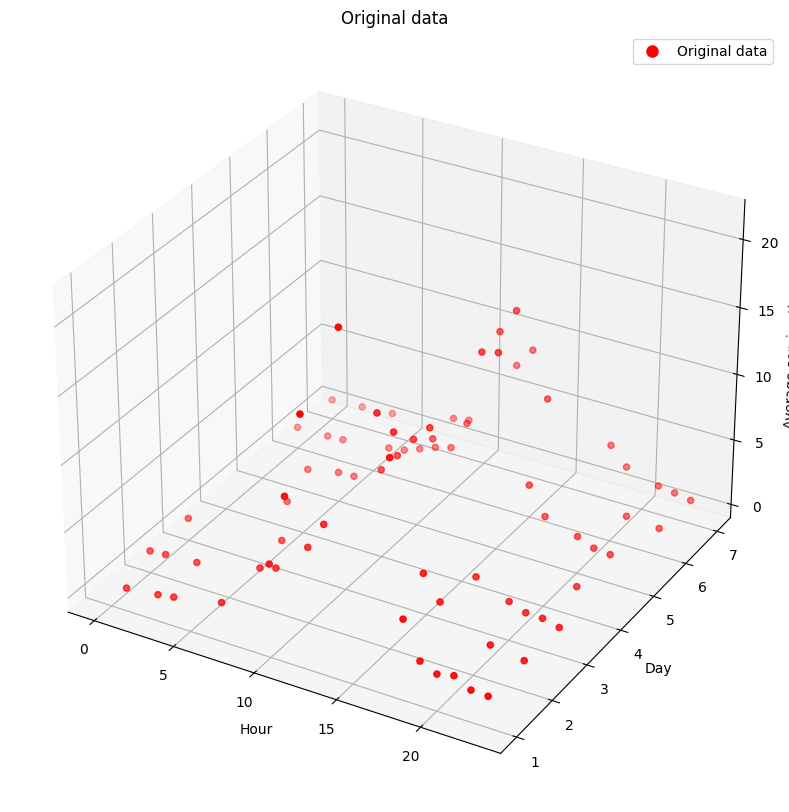

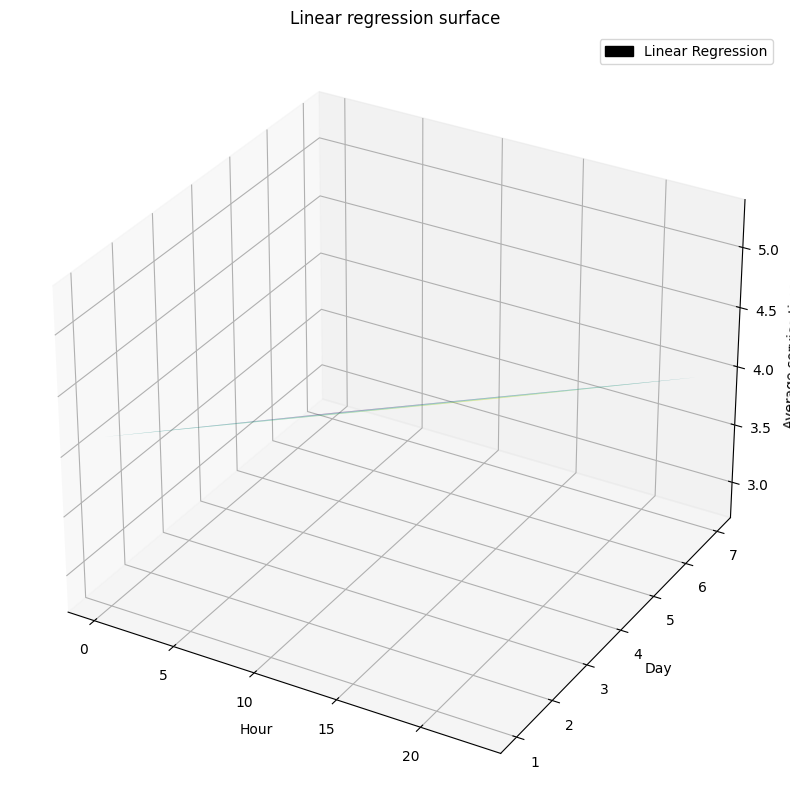

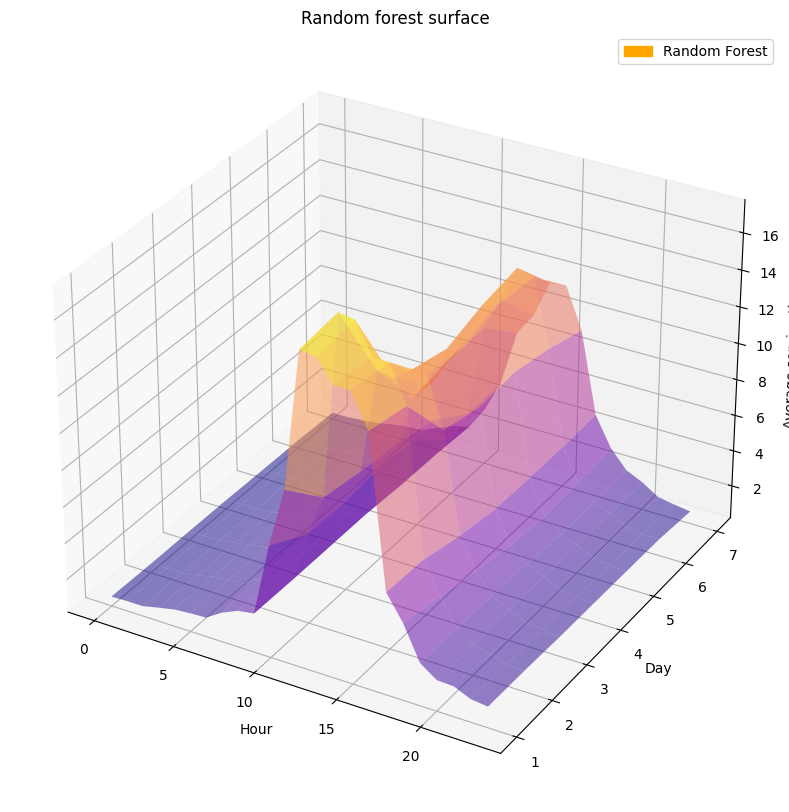

In [75]:
X, Y = np.meshgrid(mean_service_times.columns, mean_service_times.index) # Meshgrid for 3D plotting

# Plot of the original data
fig1 = plt.figure(figsize=(15, 10))
ax1 = fig1.add_subplot(111, projection='3d')
scatter = ax1.scatter(X[~np.isnan(mean_service_times)], Y[~np.isnan(mean_service_times)], 
                      mean_service_times.values[~np.isnan(mean_service_times)], c='r', marker='o')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day')
ax1.set_zlabel('Average service time')
ax1.set_title('Original data')
ax1.legend(handles=[Line2D([0], [0], marker='o', color='w', label='Original data',
                            markerfacecolor='r', markersize=10)])

# Plot of the linear regression surface
fig2 = plt.figure(figsize=(15, 10))
ax2 = fig2.add_subplot(111, projection='3d')
surf_lr = ax2.plot_surface(X, Y, y_pred_lr_reshaped, alpha=0.5, cmap='viridis')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Day')
ax2.set_zlabel('Average service time')
ax2.set_title('Linear regression surface')
ax2.legend(handles=[Patch(facecolor='black', edgecolor='black', label='Linear Regression')])

# Plot of the random forest surface
fig3 = plt.figure(figsize=(15, 10))
ax3 = fig3.add_subplot(111, projection='3d')
surf_rf = ax3.plot_surface(X, Y, y_pred_rf_reshaped, alpha=0.5, cmap='plasma')
ax3.set_xlabel('Hour')
ax3.set_ylabel('Day')
ax3.set_zlabel('Average service time')
ax3.set_title('Random forest surface')
ax3.legend(handles=[Patch(facecolor='orange', edgecolor='orange', label='Random Forest')])

plt.show()

### 4. What is the probability that the service time of chip, between 16:00 to 18:00, on Shabbat, will be between 6 to 7 seconds? 

In [76]:
shabbat_data = df_tot[(df_tot['day'] == 6) & (df_tot['hour'].isin([16, 17]))]['service_time']
mean = shabbat_data.mean()
std = shabbat_data.std()

prob = stats.norm.cdf(7, mean, std) - stats.norm.cdf(6, mean, std)
print(f"Probability of service time between 6 to 7 seconds on Shabbat between 16:00 to 18:00: {prob:.4f}")

Probability of service time between 6 to 7 seconds on Shabbat between 16:00 to 18:00: 0.0349


### 5. Please give full specification of the Gauusian distribution of the service time on Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00. 

In [77]:
def get_gaussian_params(day, hour):
    data = df_tot[(df_tot['day'] == day) & (df_tot['hour'] == hour)]['service_time']
    return data.mean(), data.std()

sun_14_15_mean, sun_14_15_std = get_gaussian_params(0, 14)
sun_16_17_mean, sun_16_17_std = get_gaussian_params(0, 16)

# Printing the mean and standard deviation of the service times to check if there are or not
# With the current data we see that these specific data for day and hour 0 and 16 are not available
print(f"Sunday 14:00-15:00: Mean = {sun_14_15_mean:.4f}, Std = {sun_14_15_std:.4f}")
print(f"Sunday 16:00-17:00: Mean = {sun_16_17_mean:.4f}, Std = {sun_16_17_std:.4f}")

# Procceding to retrieve the values from the regression model, in this case, random forest
# Inputs for the regression models
sunday_14_15 = np.array([[0, 14]])
sunday_16_17 = np.array([[0, 16]])

# Predicting the missing service times
predicted_mean_14_15 = rf.predict(sunday_14_15)[0]
predicted_mean_16_17 = rf.predict(sunday_16_17)[0]

# Since we don't have the actual data, we can use the overall standard deviation as a rough estimate
overall_std = df_tot['service_time'].std()

print(f"Predicted Sunday 14:00-15:00: Mean = {predicted_mean_14_15:.4f}, Std = {overall_std:.4f}")
print(f"Predicted Sunday 16:00-17:00: Mean = {predicted_mean_16_17:.4f}, Std = {overall_std:.4f}")

Sunday 14:00-15:00: Mean = nan, Std = nan
Sunday 16:00-17:00: Mean = nan, Std = nan
Predicted Sunday 14:00-15:00: Mean = 15.8240, Std = 9.8944
Predicted Sunday 16:00-17:00: Mean = 13.9852, Std = 9.8944


### 6. What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 16:00 to 17:00?
### What is the correlation between the service times at Sunday between 14:00 to 15:00 and Sunday between 20:00 to 21:00?
### Which correlation value is larger? does this result make sense?

In [78]:
def get_service_times(day, hour):
    """
    Retrieve service times from a DataFrame for a specific day and hour.

    Parameters:
    - day (str): The day for which to retrieve service times.
    - hour (int): The hour of the day for which to retrieve service times.

    Returns:
    - pandas.Series: A series of service times for the specified day and hour.
    """
    return df_tot[(df_tot['day'] == day) & (df_tot['hour'] == hour)]['service_time']

# Checking for available data
sun_14_15 = get_service_times(0, 14)
sun_16_17 = get_service_times(0, 16)
sun_20_21 = get_service_times(0, 20)

if sun_14_15.empty or sun_16_17.empty or sun_20_21.empty:
    # Using predicted values if data is missing
    predicted_mean_14_15 = rf.predict(np.array([[0, 14]]))[0]
    predicted_mean_16_17 = rf.predict(np.array([[0, 16]]))[0]
    predicted_mean_20_21 = rf.predict(np.array([[0, 20]]))[0]

    # Using overall standard deviation as a rough estimate
    overall_std = df_tot['service_time'].std()

    print(f"Predicted Sunday 14:00-15:00: Mean = {predicted_mean_14_15:.4f}, Std = {overall_std:.4f}")
    print(f"Predicted Sunday 16:00-17:00: Mean = {predicted_mean_16_17:.4f}, Std = {overall_std:.4f}")
    print(f"Predicted Sunday 20:00-21:00: Mean = {predicted_mean_20_21:.4f}, Std = {overall_std:.4f}")

    # Since we don't have actual data points, correlation calculation isn't meaningful with only mean values
    print("Cannot calculate correlation with predicted means alone.")
else:
    # Calculate correlations if data is available
    corr_14_15_16_17 = sun_14_15.corr(sun_16_17)
    corr_14_15_20_21 = sun_14_15.corr(sun_20_21)

    print(f"Correlation between Sunday 14:00-15:00 and 16:00-17:00: {corr_14_15_16_17:.4f}")
    print(f"Correlation between Sunday 14:00-15:00 and 20:00-21:00: {corr_14_15_20_21:.4f}")
    print(f"Larger correlation: {'14:00-15:00 and 16:00-17:00' if corr_14_15_16_17 > corr_14_15_20_21 else '14:00-15:00 and 20:00-21:00'}")

Predicted Sunday 14:00-15:00: Mean = 15.8240, Std = 9.8944
Predicted Sunday 16:00-17:00: Mean = 13.9852, Std = 9.8944
Predicted Sunday 20:00-21:00: Mean = 1.8815, Std = 9.8944
Cannot calculate correlation with predicted means alone.


## Task 3:

### For cross validation of the previuos task we wish to see how accurate our predictions. 

### We use your prediction to estimate the waiting times at each points via simulation. The better the estimation made in you GP regressior the more accurate the simulations results. 

### In this part we compare the average waiting time at each cell with the true average waiting times. The true values are loaded below into 'true_results'. 


In [79]:
true_results = pkl.load(open('../data_queueing_quiz/true_results.pkl', 'rb'))
true_results.shape

(167,)

### In true_results you have a numpy array with 167 values. The first value is the  average number of customers in the system at the end of the hour 0 day 1, the second is hour 1 day 1, and so on. This is an averge of 200 simulation runs. Note that the grid contains 168 values but here we have only 167. This means, we do not test for 23:00-0:00 at the day 7 (from technincal reasons).

### In order to compute your waiting time predictions insert your predicitons into Sim_func below. Then, the line of code below extracts the average waiting time predictions into the variable  'preds_results'.

### At this point you have two vectors of size (167,),  one represents the true average waiting times and the other represent your predicitons. 

### The first value represents the average waiting time at Sunday between 0:00-01:00. The 50th cell represent the average waiting time at Tuesday between 01:00 to 02:00. 

## Tasks

### 1. Compute the average waiting times using the function Sim_func. Compare your results between your predictions and the ground truth using MSE. 

### 2. Plot the average waiting as a function of time of the week. That is, y-axis is the average waiting time and the X-axis is the hour of the week. Following the exmaple from above Tuesday between 01:00 to 02:00 is the 50th hour. 

The linear regression model actually performed better in terms of MSE (0.523546) compared to the random forest model (4505.877244). However, the random forest model showed a much higher correlation with the true values (0.6771) than the linear regression model (0.0861). The graphs illustrate that while the random forest model captured the weekly patterns and peaks more accurately, it significantly overestimated the number of customers (maximum predicted: 376.80 vs true maximum: 2.84). The linear regression model, on the other hand, produced values closer to the true range but failed to capture the periodic fluctuations effectively, both models underestimated the average number of customers (random forest: 20.81, linear regression: 0.25, true average: 0.48).

Mean Squared Error for random forest model: 4505.877244


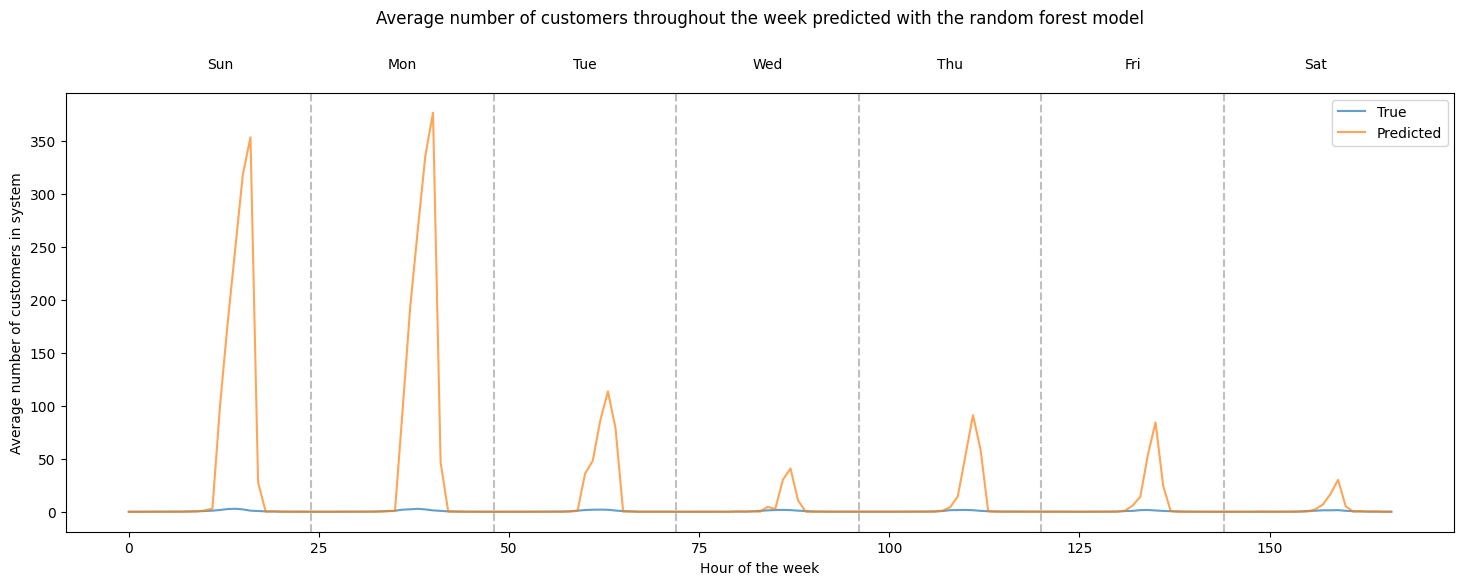

Maximum true number of customers: 2.84
Maximum predicted number of customers: 376.80
Average true number of customers: 0.48
Average predicted number of customers: 20.81
Correlation between true and predicted values for random forest model: 0.6771
Mean Squared Error for linear regression model: 0.523546


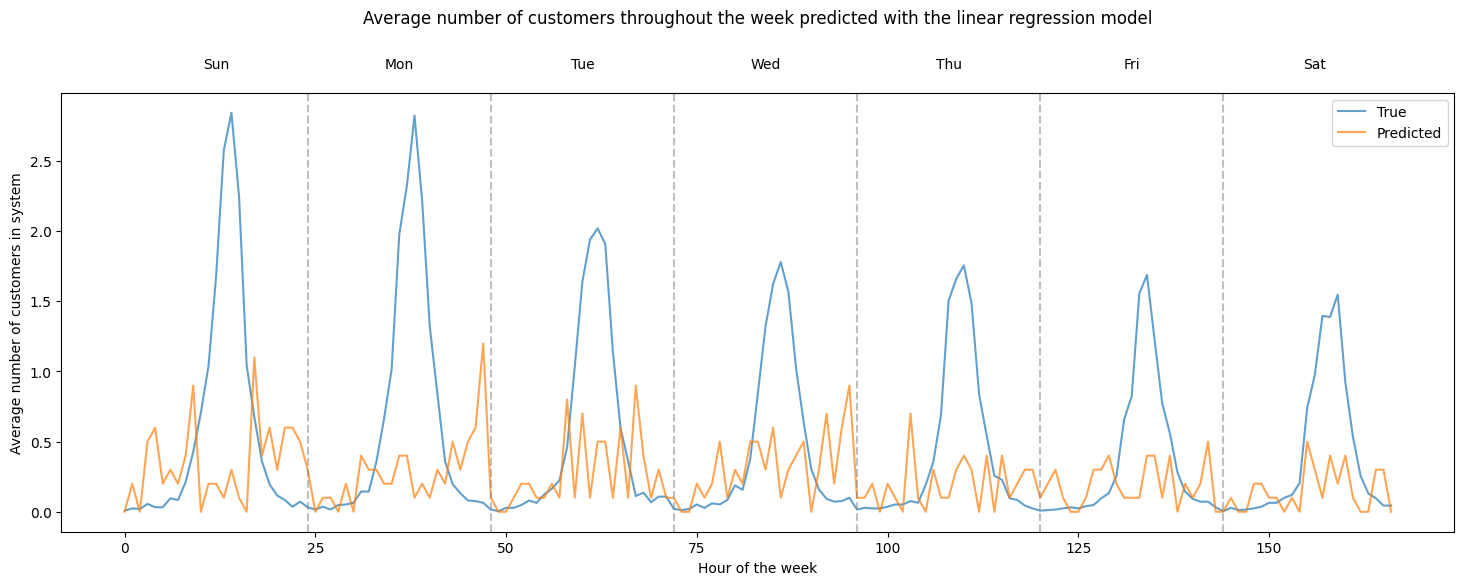

Maximum true number of customers: 2.84
Maximum predicted number of customers: 1.20
Average true number of customers: 0.48
Average predicted number of customers: 0.25
Correlation between true and predicted values for linear regression model: 0.0861


In [86]:
# We decided to run the simulation function using the two data from the two models, linear regression and random forest
def run_simulation_and_plot(your_prediction, model_name):
    # Running the simulation
    df_sim = Sim_func(your_prediction)

    # Converting simulation results to numpy array
    # We'll use the mean of all simulation runs (columns starting with 'num_cust')
    num_cust_columns = [col for col in df_sim.columns if col.startswith('num_cust')]
    preds_results = df_sim[num_cust_columns].mean(axis=1).values

    # Trim preds_results to match true_results length
    preds_results = preds_results[:len(true_results)]

    # Computing MSE as required
    mse = mean_squared_error(true_results, preds_results)
    print(f"Mean Squared Error for {model_name}: {mse:.6f}")

    #Plot of average waiting time as a function of time of the week
    plt.figure(figsize=(15, 6))
    plt.plot(np.arange(len(true_results)), true_results, label='True', alpha=0.7)
    plt.plot(np.arange(len(preds_results)), preds_results, label='Predicted', alpha=0.7)

    plt.xlabel('Hour of the week')
    plt.ylabel('Average number of customers in system')
    plt.title(f'Average number of customers throughout the week predicted with the {model_name}', pad=50)

    plt.legend()

    # Adding vertical lines to separate days
    for day in range(1, 7):
        plt.axvline(x=day*24, color='gray', linestyle='--', alpha=0.5)

    # Adding day labels
    days = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    for i, day in enumerate(days):
        plt.text(i*24 + 12, plt.ylim()[1] * 1.05, day, ha='center', va='bottom')

    plt.tight_layout(pad=2.0)
    plt.subplots_adjust(top=0.85)
    plt.show()

    # Print of some statistics
    print(f"Maximum true number of customers: {np.max(true_results):.2f}")
    print(f"Maximum predicted number of customers: {np.max(preds_results):.2f}")
    print(f"Average true number of customers: {np.mean(true_results):.2f}")
    print(f"Average predicted number of customers: {np.mean(preds_results):.2f}")

    # Calculating correlation between true and predicted values
    correlation = np.corrcoef(true_results, preds_results)[0, 1]
    print(f"Correlation between true and predicted values for {model_name}: {correlation:.4f}")

# We will use the predicted data from the models random forest and linear regression
your_prediction_rf = y_pred_rf_reshaped
your_prediction_lr = y_pred_lr_reshaped

# Simulation and plot for Random Forest model
run_simulation_and_plot(your_prediction_rf, "random forest model")

# Simulation and plot for Linear Regression model
run_simulation_and_plot(your_prediction_lr, "linear regression model")